In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas

<h1>Booking Difficulty</h1>
<ul>
<li>Scrapped in May</li>
<li>How much variation is there within a week?</li>
<li>What are the top booked locations?</li>
<li>Are they the same as the top ranked on Yelp?</li>
<li>Are there hidden gems that are easy to book but highly rated?</li>
</ul>

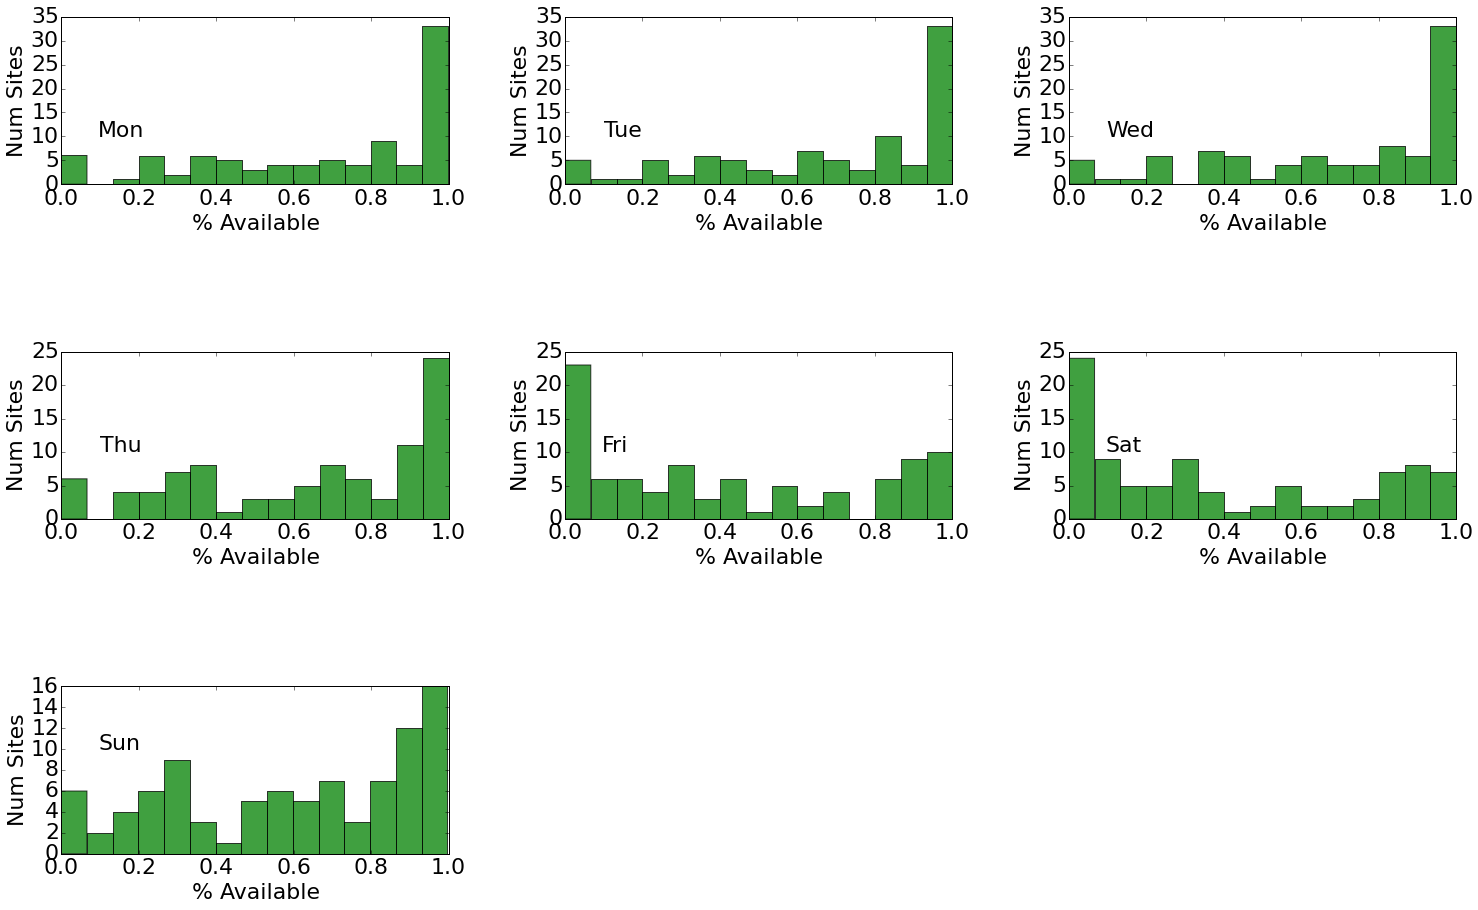

In [62]:
import pandas
import pandasql
import csv
import datetime
import numpy as np
import glob

#read in data for individual campsites
filename='~/Desktop/campy/listFiles/campSiteIndCAwADAwNumsite.csv'
dataMulti=pandas.read_csv(filename,encoding='ISO-8859-1')
#load file with avaliability information
path="campy/dataFiles/campSiteIndStatusCA*.csv"
filenames = glob.glob(path)
dfs = []
for filename in filenames:
    dfs.append(pandas.read_csv(filename))
# Concatenate all data into one DataFrame
dataSite = pandas.concat(dfs, ignore_index=True)

#A for Avaliable removing the number if multiple sites
dataSite['avaliable']=[int(filter(lambda x: x.isdigit(),numA)) if filter(lambda x: x.isdigit(),numA) else (1 if numA=='A' else 0) for numA in dataSite['status'] ]
#get the string part of the status
dataSite['status']=[''.join([i for i in numA if not i.isdigit()]) for numA in dataSite['status']]

q="""
        SELECT  dataSite.parkID,
        dataSite.dayOfWeek,
        SUM(CAST(dataMulti.numSites AS FLOAT))/COUNT(DISTINCT date) AS sitePerDate,
        SUM(CAST(dataSite.avaliable AS FLOAT))/SUM(CAST(dataMulti.numSites AS FLOAT)) AS perc, 
        SUM(dataMulti.numSites) AS totalSites, 
        COUNT(DISTINCT date) AS totalDates
        FROM dataSite 
        LEFT JOIN dataMulti 
        ON dataSite.parkID=dataMulti.parkID 
        AND dataSite.siteID=dataMulti.siteID 
        WHERE (dataSite.status="R" OR dataSite.status="A")
    AND ADA=0
        AND (  type="ENVIRONMENTAL SITE" 
            OR type="CABIN" 
            OR type="RV/TRAILER ONLY" or type="STANDARD" 
            OR type="TENT ONLY SITE" 
            OR type="TENT ONLY - WALK-IN" 
            OR type="YURT" 
            OR type="Double Hook-Up" 
            OR type="HOOK-UP" 
            OR type="CAMPING PACKAGE" 
            OR type="DELUXE CABIN" 
            OR type="COTTAGE" 
            OR type="HOTEL ROOM" )
    GROUP BY dataSite.parkID, dataSite.dayOfWeek
"""
df=pandasql.sqldf(q, locals())
# gets the perc of openings per day of week for each campground

plt.figure(figsize=(25,15))
nbins=15
plt.subplots_adjust(hspace = 1, wspace = .3)
subplotNum=[331,332,333,334,335,336,337]
subplotTitle=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
plt.rcParams.update({'font.size': 22})
for day in range(7):
    ax=plt.subplot(subplotNum[day])
    plt.hist(df['perc'][df.dayOfWeek==day].values, nbins, facecolor='green', alpha=0.75)
    ax.annotate(subplotTitle[day], xy=(0.1, 10))
    plt.xlabel('% Available')
    plt.ylabel('Num Sites')
#histogram for each day of the perc sites filled






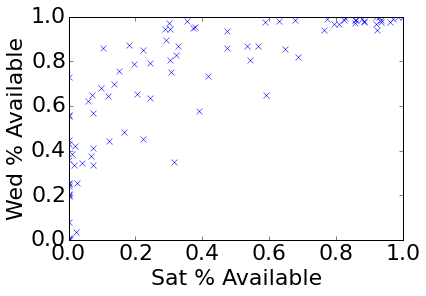

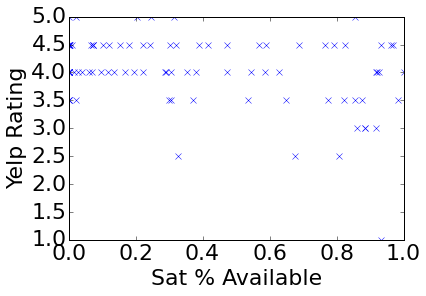

In [65]:
filename='~/Desktop/campy/listFiles/yelpReviews.csv'
dataYelp=pandas.read_csv(filename,encoding='ISO-8859-1')

q="""
    SELECT df1.parkID , df1.sitePerDate, df1.totalDates , df1.perc AS perc5, df2.perc AS perc2,rating,numReviews
        FROM df AS df1
        JOIN df AS df2
            ON df1.parkID = df2.parkID
        JOIN dataYelp
            ON dataYelp.parkID = df1.parkID
            WHERE df1.dayOfWeek=5
            AND df2.dayOfWeek=2

"""
df2=pandasql.sqldf(q, locals())
plt.figure(2)
plt.plot(df2['perc5'].values, df2['perc2'].values,'x')
plt.xlabel('Sat % Available')
plt.ylabel('Wed % Available')
plt.figure(3)
plt.plot(df2['perc5'].values, df2['rating'].values,'x')
plt.xlabel('Sat % Available')
plt.ylabel('Yelp Rating')
#print df
#plt.plot(df['perc5'].values, df['perc2'].values,'x')

<h1>Campsites Based on Climate</h1>
 <ul>
     <li>Scrapped description of campsite for 'redwood', 'beach', 'lake', and 'river'</li>
     <li>Catagorized using Holdridge life zones</li>
     <li>NOAA data dump of reduced data (avg over months) for weather stations</li>
     <li>Found closest weather station to park</li>
     <li>I like camping in desserts during the winter...</li>
     <li>Similar campsites: I enjoyed camping in this redwood forest; where are others?</li>
     <img src="Lifezones_Pengo.svg" height="600" width="600">
 </ul>


([<matplotlib.axis.XTick at 0x1231cb6d0>,
 <a list of 10 Text xticklabel objects>)

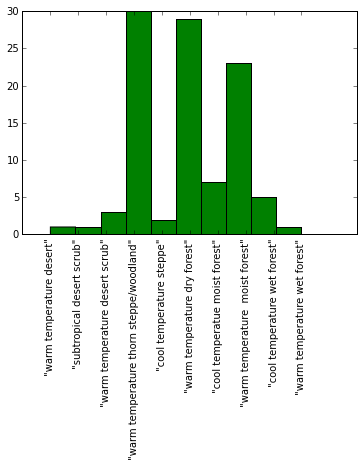

In [117]:
filename='~/Desktop/campcampyDev/campcampyWebsite/dataFiles/campGroundsCA5.csv'
campground=pandas.read_csv(filename,encoding='ISO-8859-1')
climateArray=[]
for index,name in enumerate(campground['name']):
    totTemp=0
    totPercip=0
    for month in range(1,13):
        if (campground['Tmax'+str(month)][index]-32)/1.8<30:
            totTemp+=(campground['Tmax'+str(month)][index]-32)/1.8
        else:
            totTemp+=30
        if (campground['Tmin'+str(month)][index]-32)/1.8>0:
            totTemp+=(campground['Tmin'+str(month)][index]-32)/1.8
        else:
            totTemp+=0
        if campground['Precip'+str(month)][index]!=-7777:
             totPercip+=campground['Precip'+str(month)][index]/100.0
    totPercip=totPercip*25.4
    totTemp=totTemp/240.0
    names={
'"warm temperature desert"':1,
'"subtropical desert scrub"':2,
'"warm temperature desert scrub"':3,
'"warm temperature thorn steppe/woodland"':4,
'"cool temperature steppe"':5,
'"warm temperature dry forest"':6,
'"cool temperatue moist forest"':7,
'"warm temperature  moist forest"':8,
'"cool temperature wet forest"':9,
'"warm temperature wet forest"':10    }
    if totPercip<125:
        if totTemp>24:
            climate='"tropical desert"'
        elif totTemp>17:
            climate='"subtropical desert"'
        elif totTemp>12:
            climate='"warm temperature desert"'
        elif totTemp>6:
            climate='"cool temperature desert"'
        elif totTemp>3:
            climate='"boreal desert"'
        elif totTemp>1.5:
            climate='"subpolar desert"'
        else:
            climate='"polar desert"'
    elif totPercip<250:
        if totTemp>24:
            climate='"tropical desert scrub"'
        elif totTemp>17:
            climate='"subtropical desert scrub"'
        elif totTemp>12:
            climate='"warm temperature desert scrub"'
        elif totTemp>6:
            climate='"cool temperature desert scrub"'
        elif totTemp>3:
            climate='"boreal desert dry scrub"'
        elif totTemp>1.5:
            climate='"subpolar desert moist tundra"'
        else:
            climate='"polar desert"'
    elif totPercip<500:
        if totTemp>24:
            climate='"tropical thorn woodland"'
        elif totTemp>17:
            climate='"subtropical thorn steppe/woodland"'
        elif totTemp>12:
            climate='"warm temperature thorn steppe/woodland"'
        elif totTemp>6:
            climate='"cool temperature steppe"'
        elif totTemp>3:
            climate='"boreal moist forest"'
        elif totTemp>1.5:
            climate='"subpolar wet tundra"'
        else:
            climate='"polar desert"'
    elif totPercip<1000:
        if totTemp>24:
            climate='"tropical very dry forest"'
        elif totTemp>17:
            climate='"subtropical dry forest"'
        elif totTemp>12:
            climate='"warm temperature dry forest"'
        elif totTemp>6:
            climate='"cool temperatue moist forest"'
        elif totTemp>3:
            climate='"boreal wet forest"'
        else:
            climate='"subpolar rain tundra"'
    elif totPercip<2000:
        if totTemp>24:
            climate='"tropical dry forest"'
        elif totTemp>17:
            climate='"subtropical moist forest"'
        elif totTemp>12:
            climate='"warm temperature  moist forest"'
        elif totTemp>6:
            climate='"cool temperature wet forest"'
        else:
            climate='"boreal rain forest"'
    elif totPercip<4000:
        if totTemp>24:
            climate='"tropical moist forest"'
        elif totTemp>17:
            climate='"subtropical wet forest"'
        elif totTemp>12:
            climate='"warm temperature wet forest"'
        else:
            climate='"cool temperature rain forest"'
    elif 8000:
        if totTemp>24:
            climate='"tropical wet forest"'
        elif totTemp>17:
            climate='"subtropical rain forest"'
        else:
            climate='"warm temperature rain forest"'
    else:
            climate='"tropical rain forest"'
    climateArray.append(names[climate])
nbins=10    
labels=[
'"warm temperature desert"',
'"subtropical desert scrub"',
'"warm temperature desert scrub"',
'"warm temperature thorn steppe/woodland"',
'"cool temperature steppe"',
'"warm temperature dry forest"',
'"cool temperatue moist forest"',
'"warm temperature  moist forest"',
'"cool temperature wet forest"',
'"warm temperature wet forest"']
x=[1,2,3,4,5,6,7,8,9,10]
plt.hist(climateArray, nbins, facecolor='green')
plt.xticks(x, labels, rotation='vertical')


<h1>Weather</h1>

parkID,name,zip,lat,long,Tmax1,Tmin1,Tavg1,Precip1,Tmax2,Tmin2,Tavg2,Precip2,Tmax3,Tmin3,Tavg3,Precip3,Tmax4,Tmin4,Tavg4,Precip4,Tmax5,Tmin5,Tavg5,Precip5,Tmax6,Tmin6,Tavg6,Precip6,Tmax7,Tmin7,Tavg7,Precip7,Tmax8,Tmin8,Tavg8,Precip8,Tmax9,Tmin9,Tavg9,Precip9,Tmax10,Tmin10,Tavg10,Precip10,Tmax11,Tmin11,Tavg11,Precip11,Tmax12,Tmin12,Tavg12,Precip12

COL. ALLENSWORTH SHP, CA 30.594752584
FOLSOM LAKE SRA, CA 26.5009247372
GAVIOTA SP, CA 25.1032576743
LIMEKILN SP, CA 34.2437557699
MANCHESTER SP, CA 45.8672688913
TURLOCK LAKE SRA, CA 26.7203732179
VANDAMME SP, CA 26.0260926059


(array([ 15.,  10.,  14.,  13.,  23.,  14.,   3.,   3.,   4.,   1.,   0.,
          1.,   0.,   0.,   1.]),
 array([  0.08226153,   3.13459535,   6.18692918,   9.239263  ,
         12.29159682,  15.34393065,  18.39626447,  21.4485983 ,
         24.50093212,  27.55326595,  30.60559977,  33.65793359,
         36.71026742,  39.76260124,  42.81493507,  45.86726889]),
 <a list of 15 Patch objects>)

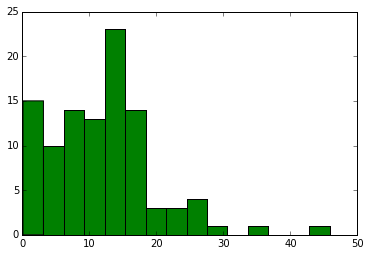

In [53]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6367 * c
    return km


filename="~/Desktop/campy/campGroundsCA4.csv"
dataFac=pandas.read_csv(filename,encoding='ISO-8859-1')

filename="~/Desktop/campy/weatherFiles/allstations.csv"
dataStation=pandas.read_csv(filename,encoding='ISO-8859-1')
filename="~/Desktop/campy/weatherFiles/mly-tmax-normal.txt"
dataTmax=pandas.read_csv(filename,encoding='ISO-8859-1')
filename="~/Desktop/campy/weatherFiles/mly-tmin-normal.txt"
dataTmin=pandas.read_csv(filename,encoding='ISO-8859-1')
filename="~/Desktop/campy/weatherFiles/mly-prcp-normal.txt"
dataPercip=pandas.read_csv(filename,encoding='ISO-8859-1')

#print 'parkID,name,zip,lat,long,\
#Tmax1,Tmin1,Tavg1,Precip1,\
#Tmax2,Tmin2,Tavg2,Precip2,\
#Tmax3,Tmin3,Tavg3,Precip3,\
#Tmax4,Tmin4,Tavg4,Precip4,\
#Tmax5,Tmin5,Tavg5,Precip5,\
#Tmax6,Tmin6,Tavg6,Precip6,\
#Tmax7,Tmin7,Tavg7,Precip7,\
#Tmax8,Tmin8,Tavg8,Precip8,\
#Tmax9,Tmin9,Tavg9,Precip9,\
#Tmax10,Tmin10,Tavg10,Precip10,\
#Tmax11,Tmin11,Tavg11,Precip11,\
#Tmax12,Tmin12,Tavg12,Precip12\n'

mindistArray=[]
for n,parkID in enumerate(dataFac['parkID']):
    minStationID=''
    minDist=99999
    minLat=0
    minLong=0
    for m,stationID in enumerate(dataStation['stationID']):
        #if dataStation['state'][m]=='CA':
            lon1=dataStation['long'][m]
            lat1=dataStation['lat'][m]
            lon2=dataFac['long'][n]
            lat2=dataFac['lat'][n]
            currentDist=haversine(lon1, lat1, lon2, lat2)
            if currentDist<minDist and (stationID in dataTmax.stationID.values) and (stationID in dataTmin.stationID.values) and (stationID in dataPercip.stationID.values): 
                minDist=currentDist
                minStationID=stationID
                #print stationID in dataTmax.stationID.values
                minLat=lat1
                minLong=lon1

    stringOutput=str(dataFac['parkID'][n])+',"'+str(dataFac['name'][n])+'",'+str(dataFac['zip'][n])+','+str(dataFac['lat'][n])+','+str(dataFac['long'][n])
    arrayMonths=['1M','2M','3M','4M','5M','6M','7M','8M','9M','10M','11M','12M']
    for month in arrayMonths:
            stringOutput+=','+filter(lambda x: x.isdigit(),str(dataTmax[dataTmax.stationID==minStationID][month].iloc[0]))+','+\
                filter(lambda x: x.isdigit(),str(dataTmin[dataTmin.stationID==minStationID][month].iloc[0]))+','+\
                filter(lambda x: x.isdigit(),str(dataPercip[dataPercip.stationID==minStationID][month].iloc[0])).replace('7777','-7777')#+\
    if minDist>25:
        print dataFac['name'][n],minDist
    mindistArray.append(minDist)
    #print stringOutput
plt.figure()
nbins=15    
plt.hist(mindistArray, nbins, facecolor='green')